## ADALINE (Adaptive Linear Neuron)

単一層ニューラルネットワーク。パーセプトロンアルゴリズムの改良とみなすことができるアルゴリズム
主な違いは、重みの更新方法が異なる。

### 概要

```
バイアス
入力X = 重みW => 総入力関数 Σ => 活性化関数 ==+=> 量子化器 => 出力
                                <= (重みの更新) = 誤差 」
```

* コスト関数J

誤差平方和(Sum of Squared Error)
J(w) = 1/2 Σ (y - φ(z))^2
1/2は便宜上追加したもので、勾配が得やすくなる。
このコスト関数は凸関数なので、勾配降下法(gradient descent)を用いて、コスト関数を最小化する重みを見つけれる。

* 勾配硬化法
コストが大局的最小値に達するまで坂を下るもの。
凸関数となっている場合、「傾き = 0」 になる箇所がコスト（誤差）が0ということで大局的最小値ということ。

参考: Python機械学習プログラム第2章


# ADALINEクラスの定義

In [8]:
import numpy as np

class AdalineGD(object):
    """Adaptive Liner Neuron"""
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        """トレーニングデータに適合させる"""
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = [] # 各エポックごとのコストを格納する配列
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output) # 誤差
            self.w_[1:] += self.eta * X.T.dot(errors) # wjの更新
            self.w_[0] += self.eta * errors.sum() # w0の更新
            cost = (errors**2).sum() / 2.0 # コスト関数 J(W) = 1/2Σ(y-φ(z))^2
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """総入力の計算"""
        return np.dot(X, self.w_[1:]) + self.w_[0] # WX
    
    def activation(self, X):
        """活性化関数の計算
        　　　　　ADALINEでは φ(W' X) = W' X となるのでnet_inputをそのまま返している
        """
        return self.net_input(X)
    
    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)

# 学習曲線を表示する

## データの取得

In [6]:
import pandas as pd
import numpy as np

# UCI Machine Learning Repository から Irisデータ・セットを読み込む
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                               header=None)

y = df.iloc[0:100, 4].values # 1-100行目の目的変数(index 4)を取得
y = np.where(y == 'Iris-setosa', -1, 1) # Iris-setosa を -1, Iris-virginica を 1 に変換
X = df.iloc[0:100, [0, 2]].values # 1-100行目の1, 3列目(index 0, 2)を取得

## 学習率 0.01 vs 0.0001 の学習曲線を表示

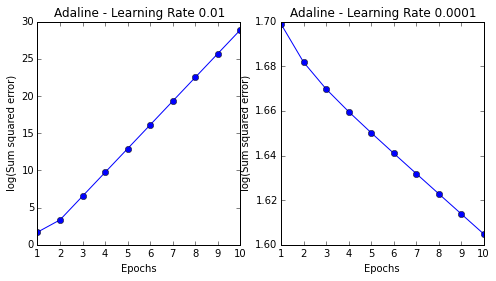

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

# 描画領域を1行2列に分割
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# 勾配降下法によるADALINEの学習 (eta = 0.01)
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)

# ada1のコストの描画
ax[0].plot(range(1, len(ada1.cost_)+1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum squared error)')
ax[0].set_title('Adaline - Learning Rate 0.01')


# 勾配降下法によるADALINEの学習 (eta = 0.0001)
ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)

# ada2のコストの描画
ax[1].plot(range(1, len(ada2.cost_)+1), np.log10(ada2.cost_), marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('log(Sum squared error)')
ax[1].set_title('Adaline - Learning Rate 0.0001')

# 図の表示 
plt.show()

# 学習率 0.01だとエラーが上昇しているので発散してしまているのでうまく学習できてない
# 学習率 0.0001 だとエラーが降下しているので収束しているのでうまく学習できている

# アルゴリズムの改善

## 標準化(Standardization)
学習率 0.0001で収束していてうまく学習できているが、とても小さい値なので、収束し終わるまで時間がかかってしまう。
そのため、「標準化」というスケーリング手法を使う。具体的には、データに標準正規分布の特性を与える。各特徴量の平均を0とし、標準偏差を1にする。

x'j = (xj - μj) / σj  ※ μ: 平均, σ: 偏差

In [10]:
X_std = np.copy(X) # コピー

# 各列の標準化
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

## 再度学習を行う
標準化した入力値X_stdで学習率 0.01で再度学習を行う

In [11]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

## 境界領域のプロット

In [15]:
# 2次元のデータセットの決定境界 (decision boundary) を可視化するメソッドの定義
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # グリッドポイントの作成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                              np.arange(x2_min, x2_max, resolution))
    
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.4)
    
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8,
                            c=cmap(idx), marker=markers[idx], label=cl)

/Users/nipe/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


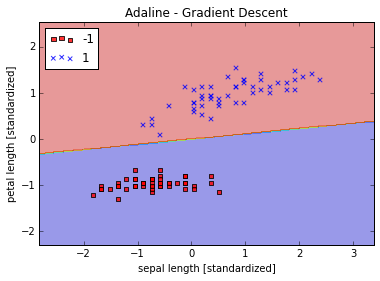

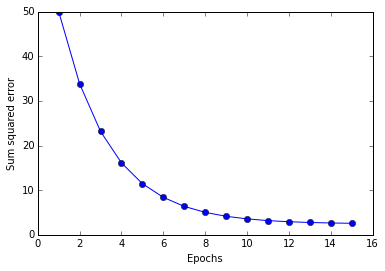

In [18]:
# 境界曲線を表示
plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.show()

# 学習曲線を表示
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum squared error')
plt.show()